<a href="https://colab.research.google.com/github/jlzhang93/relax_challenge/blob/master/relax_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [0]:
users = pd.read_csv('takehome_users.csv', encoding="ISO-8859-1")

In [5]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Missing values need to be filled for this csv. The missing values in `last_session_creation_time` are filled with the `creation_time`.

In [0]:
users['email'] = users.email.str.split('@').str[1].str.split('.').str[0].astype(
    'category')

Email domain is truncated as a feature.

In [0]:
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['creation_source'] = users['creation_source'].astype('category')
users['opted_in_to_mailing_list'] = users['opted_in_to_mailing_list'
                                          ].astype('bool')
users['enabled_for_marketing_drip'] = users['enabled_for_marketing_drip'
                                          ].astype('bool')
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(99999).astype(
    'int')
users = users.set_index('object_id')

Features are adjusted to the appropriate data types. The missing values of `invited_by_user_id` are filled with 99999.

In [0]:
from datetime import datetime
filler = (users['creation_time'] - datetime(1970, 1, 1, 0, 0, 0)).dt.total_seconds()
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(
   filler)
users['last_session_creation_time'] = pd.to_datetime(users[
                                    'last_session_creation_time'], unit='s')

Values from `creation_time` are converted to unix timestamp first and are then used to fill the `NaN`s of `last_session_creation_time`. After that, the unix timestamps in `last_session_creation_time` are converted to datetime type.

In [10]:
engagement = pd.read_csv('takehome_user_engagement.csv', encoding="ISO-8859-1",
                         parse_dates=['time_stamp'])
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [11]:
engagement['time_stamp'] = engagement['time_stamp'].dt.date
s = engagement.groupby(['user_id', 'time_stamp']).visited.count()
s.value_counts()

1    207917
Name: visited, dtype: int64

This shows that any user logs into the product at most once per day.

In [0]:
engagement['time_stamp'] = pd.to_datetime(engagement.time_stamp)

sorted = engagement.set_index('time_stamp').groupby(
    'user_id').resample('7d').visited.count()

adopted_id = sorted[sorted >= 3].index.get_level_values(0).unique()

`Adopted_id` includes ids of all users  that have logged into the product on three separate days in at least 7-day period 

In [0]:
for row in users.itertuples():
    if row.Index in adopted_id:
        users.loc[row.Index, 'adopted'] = True
    else:
        users.loc[row.Index, 'adopted'] = False

The target is added as `adopted`. If the id of a user is in `adopted_id`, then `adopted` is marked as `True` (1), or it is marked as `False` (0). 

In [0]:
users['duration'] = (users['last_session_creation_time'] - 
                     users['creation_time']).dt.days
users.drop(['creation_time', 'last_session_creation_time'], axis=1, inplace=True)
users = users.reset_index()

The time between signup date and the last login date is saved as a new feature `duration`

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   object_id                   12000 non-null  int64   
 1   name                        12000 non-null  object  
 2   email                       12000 non-null  category
 3   creation_source             12000 non-null  category
 4   opted_in_to_mailing_list    12000 non-null  bool    
 5   enabled_for_marketing_drip  12000 non-null  bool    
 6   org_id                      12000 non-null  int64   
 7   invited_by_user_id          12000 non-null  int64   
 8   adopted                     12000 non-null  object  
 9   duration                    12000 non-null  int64   
dtypes: bool(2), category(2), int64(4), object(2)
memory usage: 670.7+ KB


Now all missing values are filled in.

In [0]:
users.drop(['name', 'object_id'], axis=1, inplace=True)
users['org_id'] = users['org_id'].astype('category')
users['invited_by_user_id'] = users['invited_by_user_id'].astype('category')

In [0]:
users['if_invited'] = users['invited_by_user_id'] == 99999

Another feature `if_invited` is added and is marked as `True` if a user is invited by another user.

In [0]:
y = users['adopted'].astype(int)
X = users.drop(['adopted'], axis=1)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import lightgbm as lgb

In [0]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25,
                                                random_state=7)

In [21]:
cl = lgb.LGBMClassifier()
cl.fit(Xtrain, ytrain)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

A light gradient boost machine classifier is used here.

In [0]:
ypred = cl.predict(Xtest)

In [23]:
print('The accuracy score is {}.'.format(accuracy_score(ypred, ytest)))
print('The F1 score is {}.'.format(f1_score(ypred, ytest)))
print('The ROC AUC score is {}.'.format(roc_auc_score(ypred, ytest)))

The accuracy score is 0.9726666666666667.
The F1 score is 0.8831908831908831.
The ROC AUC score is 0.9484371318446334.


In [0]:
importance = pd.DataFrame(cl.feature_importances_, index=X.columns, 
             columns=['feature_importance']).sort_values('feature_importance')

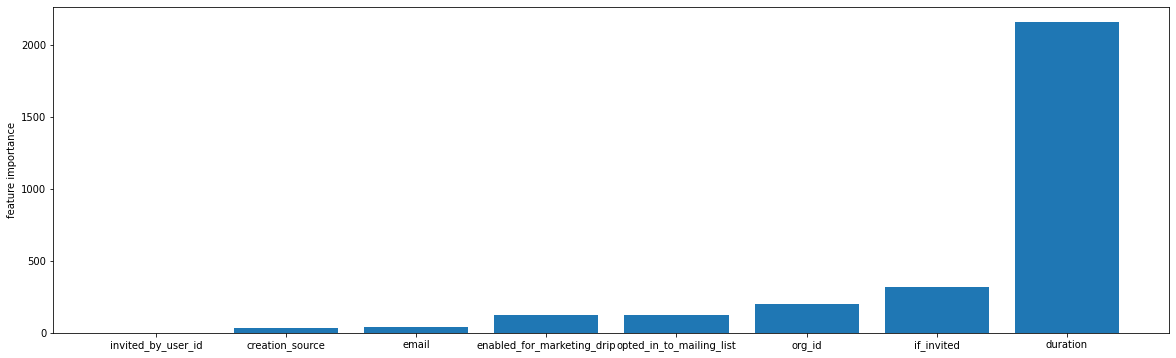

In [37]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 6))
plt.bar(importance.index, importance.feature_importance)
plt.ylabel('feature importance')
plt.show()

The longer a user stays with the product (longer duration), the more likely that this user is an adopted user. And if users are invited by other users, they are more likely to be adopted users.